# 0

In [1]:
from google.colab import drive, userdata
import os, numpy as np

drive.mount("/content/drive", force_remount=False)

BASE_DIR = f"/content/drive/MyDrive/{userdata.get("drive_folder_name")}"
PROCESSED_DIR = f"{BASE_DIR}/data/processed"

embeddings = np.load(f"{PROCESSED_DIR}/minilm_embeddings.npy")
confidences = np.load(f"{PROCESSED_DIR}/confidences.npy")

strong_bully = np.load(f"{PROCESSED_DIR}/strong_bully_idx.npy")
strong_safe  = np.load(f"{PROCESSED_DIR}/strong_safe_idx.npy")
ambiguous    = np.load(f"{PROCESSED_DIR}/ambiguous_idx.npy")

print("Embeddings:", embeddings.shape)


Mounted at /content/drive
Embeddings: (34020, 384)


# 1 Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import matplotlib.pyplot as plt


# ** Architecture (and dependent classes) - COPIED from previous notebook)

* Should import in the future from a Google Drive folder

## X Base architecture (MAB, PMA, ISAB)

In [3]:
class MAB(nn.Module):
    # Multihead Attention Block
    def __init__(self, dim_Q, dim_KV, dim_out, num_heads=4):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim_out, num_heads=num_heads, batch_first=True)
        self.fc_q = nn.Linear(dim_Q, dim_out)
        self.fc_k = nn.Linear(dim_KV, dim_out)
        self.fc_v = nn.Linear(dim_KV, dim_out)

        self.ln1 = nn.LayerNorm(dim_out)
        self.ln2 = nn.LayerNorm(dim_out)

        self.ff = nn.Sequential(
            nn.Linear(dim_out, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, Q, KV):
        Q_ = self.fc_q(Q)
        K_ = self.fc_k(KV)
        V_ = self.fc_v(KV)

        H, _ = self.mha(Q_, K_, V_)
        H = self.ln1(H + Q_)
        O = self.ln2(H + self.ff(H))
        return O


class ISAB(nn.Module):
    # Induced Set Attention Block (corrected)
    def __init__(self, dim_in, dim_out, num_heads=4, num_inducing=16):
        super().__init__()

        self.proj = nn.Linear(dim_in, dim_out)
        self.I = nn.Parameter(torch.randn(1, num_inducing, dim_out))

        # Both MABs now operate in dim_out space
        self.mab1 = MAB(
            dim_Q=dim_out,
            dim_KV=dim_out,
            dim_out=dim_out,
            num_heads=num_heads
        )

        self.mab2 = MAB(
            dim_Q=dim_out,
            dim_KV=dim_out,
            dim_out=dim_out,
            num_heads=num_heads
        )

    def forward(self, X):
        # X: [B, N, dim_in]
        Xp = self.proj(X)             # [B, N, dim_out]
        B = Xp.size(0)
        I = self.I.expand(B, -1, -1)  # [B, m, dim_out]

        H = self.mab1(I, Xp)          # [B, m, dim_out]
        O = self.mab2(Xp, H)          # [B, N, dim_out]
        return O


class PMA(nn.Module):
    # Pooling by Multihead Attention
    def __init__(self, dim, num_heads=4, num_seeds=1):
        super().__init__()
        self.S = nn.Parameter(torch.randn(1, num_seeds, dim))
        self.mab = MAB(dim_Q=dim, dim_KV=dim, dim_out=dim, num_heads=num_heads)

    def forward(self, X):
        B = X.size(0)
        S = self.S.expand(B, -1, -1)
        return self.mab(S, X)  # [B, num_seeds, dim]


## X Dual Head Set Transformer Architecture

In [4]:
# --- Add split between Single Head SetTransformer and Dual Head Transformer

class SetTransformerDualHead(nn.Module):
    def __init__(self, dim_in=384, dim=256, num_heads=4, num_inducing=16):
        super().__init__()
        self.enc1 = ISAB(dim_in, dim, num_heads, num_inducing)
        self.enc2 = ISAB(dim, dim, num_heads, num_inducing)
        self.pool = PMA(dim, num_heads, num_seeds=1)

        trunk = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.ReLU()
        )
        self.trunk = trunk

        # Two heads
        self.head_mean = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.head_topk = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())

    def forward(self, X):
        H = self.enc1(X)
        H = self.enc2(H)
        P = self.pool(H).squeeze(1)      # [B, dim]
        Z = self.trunk(P)                # [B, 128]

        mean_hat = self.head_mean(Z).squeeze(-1)  # [B]
        topk_hat = self.head_topk(Z).squeeze(-1)  # [B]

        return torch.stack([mean_hat, topk_hat], dim=1)  # [B, 2]


# 2 Build index

In [5]:
KNN_K = 128  # neighbors per anchor

knn = NearestNeighbors(
    n_neighbors=KNN_K,
    metric="cosine",
    algorithm="auto"
)

knn.fit(embeddings)

print("kNN index ready")


kNN index ready


# 3 KNN Cluster dataset

In [6]:
# --- 5 iteration
def gini(x):
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


class KNNClusterDataset(Dataset):
    def __init__(
        self,
        embeddings,
        confidences,
        knn,
        cluster_size=64,
        n_clusters=6000,
        mix_ratio=0.3,   # how much randomness to inject
    ):
        self.emb = embeddings
        self.conf = confidences
        self.knn = knn
        self.cluster_size = cluster_size
        self.n_clusters = n_clusters
        self.mix_ratio = mix_ratio
        self.N = embeddings.shape[0]

    def __len__(self):
        return self.n_clusters

    def __getitem__(self, idx):
        # 1. pick a random anchor
        anchor = np.random.randint(0, self.N)

        # 2. get semantic neighbors
        _, nbrs = self.knn.kneighbors(
            self.emb[anchor].reshape(1, -1),
            return_distance=True
        )
        nbrs = nbrs[0]

        # 3. sample mostly from neighbors, some random noise
        n_local = int(self.cluster_size * (1 - self.mix_ratio))
        n_random = self.cluster_size - n_local

        local_idx = np.random.choice(nbrs, n_local, replace=False)
        rand_idx = np.random.choice(self.N, n_random, replace=False)

        indices = np.concatenate([local_idx, rand_idx])
        np.random.shuffle(indices)

        X = self.emb[indices]
        conf = self.conf[indices]


        # Smooth label: mean bullying intensity
        # --- 1
        # y = float(conf.mean())


        # --- 2
        # topk = np.sort(conf)[-10:]
        # y = float(topk.mean())

        # return (
        #     torch.tensor(X, dtype=torch.float32),
        #     torch.tensor(y, dtype=torch.float32)
        # )


        # --- 3
        # Smooth labels (two targets)
        # y_mean = float(conf.mean())

        # k = max(5, int(0.15 * len(conf)))   # e.g., top 15% (for N=64 => k~9-10)
        # topk = np.sort(conf)[-k:]
        # y_topk = float(topk.mean())

        # y = torch.tensor([y_mean, y_topk], dtype=torch.float32)   # shape [2]


        # --- 4
        # y_mean = float(conf.mean())

        # k = max(5, int(0.15 * len(conf)))
        # topk_mean = float(np.sort(conf)[-k:].mean())

        # # 🔥 KEY CHANGE: contrast, not raw top-k
        # y_topk = topk_mean - y_mean
        # y_topk = np.clip(y_topk, 0.0, 1.0)

        # y = torch.tensor([y_mean, y_topk], dtype=torch.float32)


        # --- 5 introducing gini
        y_mean = float(conf.mean())

        # concentration, not magnitude
        y_topk = gini(conf)   # or entropy-based version

        y = torch.tensor([y_mean, y_topk], dtype=torch.float32)

        return torch.tensor(X, dtype=torch.float32), y


# 4 Data Loader

In [7]:
knn_dataset = KNNClusterDataset(
    embeddings,
    confidences,
    knn,
    cluster_size=64,
    n_clusters=6000,
    mix_ratio=0.3
)

knn_loader = DataLoader(knn_dataset, batch_size=32, shuffle=True, drop_last=True)

print("kNN cluster dataset ready")


kNN cluster dataset ready


# X Explore data

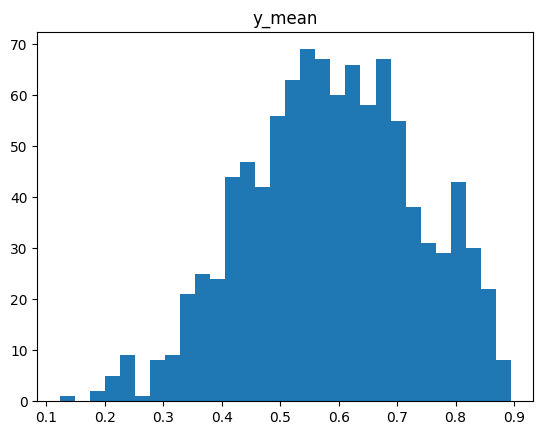

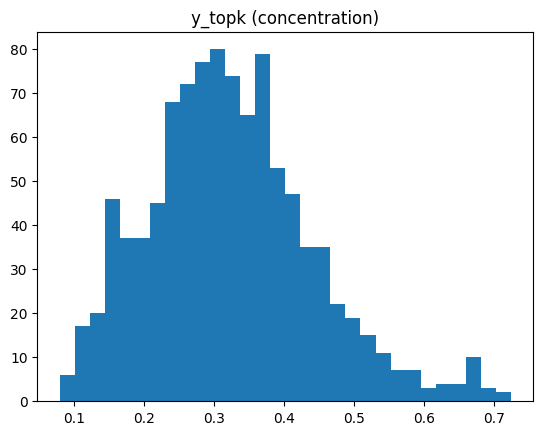

In [8]:
# --- 4th KNNClusterDataset iteration - Sanity

ys_mean, ys_topk = [], []

for i in range(1000):
    _, y = knn_dataset[i]
    ys_mean.append(y[0].item())
    ys_topk.append(y[1].item())

plt.hist(ys_mean, bins=30); plt.title("y_mean"); plt.show()

# 4th iteration - excess - sanity
# plt.hist(ys_topk, bins=30); plt.title("y_topk (excess)"); plt.show()

# 5th iteration - concentration - sanity
plt.hist(ys_topk, bins=30); plt.title("y_topk (concentration)"); plt.show()

# 6 Train

## x Dual heads (mean & topk)

In [9]:
# --- Train on both heads

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SetTransformerDualHead().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- 1 - Using BCE (I think, need to double check)

# --- 2 - Using Smooth for smoothing values,
# criterion = nn.SmoothL1Loss()
# w_mean = 1.0
# w_topk = 2.0   # emphasize concentration risk a bit more

# --- 3 - Using MSELoss() to penalize flat predictions harder
# --- 4 - Change topk to represent concentration vs. volume (? - need to validate it)
# criterion = nn.MSELoss()

# --- 5 - Replace MSELoss() with quantile (pinball) loss.
def quantile_loss(y_hat, y, q):
    # y_hat, y: [B]
    diff = y - y_hat
    return torch.mean(torch.maximum(q * diff, (q - 1) * diff))


def ranking_loss(y_hat, y, margin=0.05):
    """
    y_hat, y: [B]
    Enforces ordering consistency inside the batch
    """
    B = y.shape[0]
    if B < 2:
        return torch.tensor(0.0, device=y.device)

    # pairwise differences
    dy = y.unsqueeze(0) - y.unsqueeze(1)
    dh = y_hat.unsqueeze(0) - y_hat.unsqueeze(1)

    # only care about pairs with different targets
    mask = dy > 0
    if mask.sum() == 0:
        return torch.tensor(0.0, device=y.device)

    return torch.mean(torch.relu(margin - dh[mask]))


w_mean = 1.0
w_topk = 4.0 # Harder signal, higher weight

for epoch in range(5):
    model.train()
    total = 0.0

    for X, y in tqdm(knn_loader):
        X = X.to(device)      # [B, N, D]
        y = y.to(device)      # [B, 2]

        optimizer.zero_grad()
        y_hat = model(X)      # [B, 2]

        # ---- shape safety ----
        if y_hat.dim() == 1:
            y_hat = y_hat.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(0)

        # --- 4
        # loss_mean = criterion(y_hat[:, 0], y[:, 0])
        # loss_topk = criterion(y_hat[:, 1], y[:, 1])

        # --- 5
        # quantiles you care about
        # q_mean = 0.5      # median harm
        # q_topk = 0.8      # high-risk concentration

        # loss_mean = quantile_loss(y_hat[:, 0], y[:, 0], q_mean)
        # loss_topk = quantile_loss(y_hat[:, 1], y[:, 1], q_topk)

        # loss = w_mean * loss_mean + w_topk * loss_topk


        # -- 6 - hybrid loss --> quantile_loss (spread) + monotonic_loss (order)

        q_mean = 0.5      # median harm
        q_topk = 0.8      # high-risk concentration

        # quantile losses
        loss_mean_q = quantile_loss(y_hat[:, 0], y[:, 0], q_mean)
        loss_topk_q = quantile_loss(y_hat[:, 1], y[:, 1], q_topk)

        # ranking losses
        loss_mean_rank = ranking_loss(y_hat[:, 0], y[:, 0])
        loss_topk_rank = ranking_loss(y_hat[:, 1], y[:, 1])

        # combine
        loss = (
            w_mean * (loss_mean_q + 0.5 * loss_mean_rank) +
            w_topk * (loss_topk_q + 1.0 * loss_topk_rank)
        )

        loss.backward()
        optimizer.step()
        total += loss.item()

    print(f"Epoch {epoch+1} | loss={total/len(knn_loader):.6f} | mean_q={loss_mean_q.item():.4f} topk_1={loss_mean_q.item():.4f}")


100%|██████████| 187/187 [05:49<00:00,  1.87s/it]


Epoch 1 | loss=0.435634 | mean_q=0.0550 topk_1=0.0550


100%|██████████| 187/187 [05:47<00:00,  1.86s/it]


Epoch 2 | loss=0.429119 | mean_q=0.0527 topk_1=0.0527


100%|██████████| 187/187 [05:47<00:00,  1.86s/it]


Epoch 3 | loss=0.430175 | mean_q=0.0611 topk_1=0.0611


100%|██████████| 187/187 [05:47<00:00,  1.86s/it]


Epoch 4 | loss=0.431343 | mean_q=0.0559 topk_1=0.0559


100%|██████████| 187/187 [05:46<00:00,  1.85s/it]

Epoch 5 | loss=0.428880 | mean_q=0.0517 topk_1=0.0517


# X Save model


In [10]:
MODEL_DIR = f"{BASE_DIR}/models/cluster_model"
os.makedirs(MODEL_DIR, exist_ok=True)

torch.save(model.state_dict(), f"{MODEL_DIR}/settransformer_knn_pretrained.pt")

print("✅ Cluster model saved")

✅ Cluster model saved


## X Load model from drive (if not saving)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_DIR = f"{BASE_DIR}/models/cluster_model"

model = SetTransformerDualHead().to(device)
model.load_state_dict(torch.load(f"{MODEL_DIR}/settransformer_knn_pretrained.pt"))

<All keys matched successfully>

# 7 Evaluate model


## X Collect aligned ground truth + predictions


In [12]:
import numpy as np
model.eval()

ys_mean, ys_topk = [], []
ph_mean, ph_topk = [], []

with torch.no_grad():
    for i in range(800):
        X, y = knn_dataset[i]      # ✅ FIXED
        X = X.unsqueeze(0).to(device)
        y_hat = model(X).cpu().numpy()[0]

        ys_mean.append(y[0].item())
        ys_topk.append(y[1].item())
        ph_mean.append(y_hat[0])
        ph_topk.append(y_hat[1])

ys_mean = np.array(ys_mean)
ys_topk = np.array(ys_topk)
ph_mean = np.array(ph_mean)
ph_topk = np.array(ph_topk)

## X Rank correlation (PRIMARY metric)
This answers: “Does the model preserve ordering?”

In [13]:
from scipy.stats import spearmanr

rho_mean, _ = spearmanr(ys_mean, ph_mean)
rho_topk, _ = spearmanr(ys_topk, ph_topk)

print("Spearman(mean):", rho_mean)
print("Spearman(topk):", rho_topk)

Spearman(mean): 0.7543401485150308
Spearman(topk): 0.7216749279294635


## 7.a. Prediction spread sanity check (collapse detection)
This answers: “Is the model producing variance or a constant?”

In [14]:
print("Mean head:")
print("  min / max:", ph_mean.min(), ph_mean.max())
print("  std:", ph_mean.std())

print("Topk head:")
print("  min / max:", ph_topk.min(), ph_topk.max())
print("  std:", ph_topk.std())

Mean head:
  min / max: 0.5868498 0.5868552
  std: 8.9628224e-07
Topk head:
  min / max: 0.39610407 0.39610863
  std: 7.5657186e-07


## X Calibration scatter (GLOBAL)
This answers: “Is prediction roughly monotonic?”

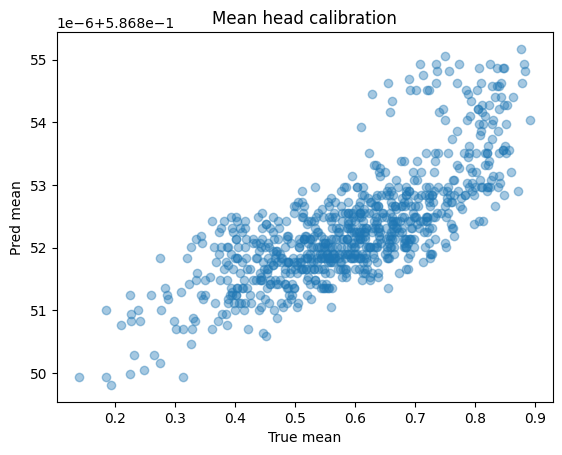

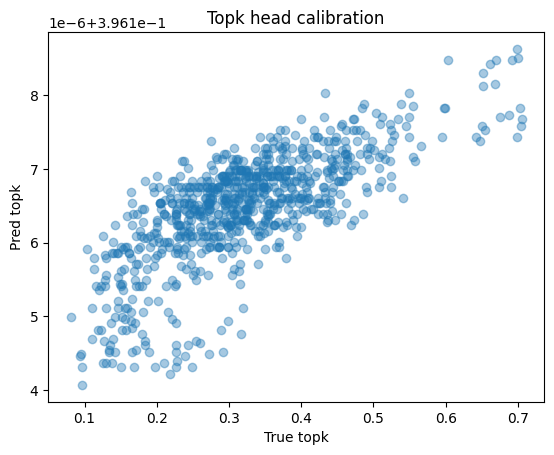

In [15]:
plt.scatter(ys_mean, ph_mean, alpha=0.4)
plt.xlabel("True mean")
plt.ylabel("Pred mean")
plt.title("Mean head calibration")
plt.show()

plt.scatter(ys_topk, ph_topk, alpha=0.4)
plt.xlabel("True topk")
plt.ylabel("Pred topk")
plt.title("Topk head calibration")
plt.show()

## X Zoomed calibration (HIGH-RISK REGION)
This replaces generic calibration for safety use-cases.

1️⃣ What is “zoomed calibration” (plain language)

Calibration asks:

“When the model predicts X, does reality look like X?”

Zoomed calibration means:

“Only check this question in the danger zone.”

In your case:

You don’t care if low-risk clusters are slightly off

You do care a lot if high-risk bullying clusters are mis-estimated

So instead of plotting all data, you:

Filter to true_topk > threshold (e.g. 0.6)

Plot only that slice

This answers:

“When harm is already high, does the model react proportionally?”

That’s exactly what you did.


2️⃣ What your plot is showing (interpretation)
Your plot (reworded)

X-axis (true topk): 0.6 → 0.7

Y-axis (predicted topk): ~0.39 (almost constant)

Red dashed line: ideal calibration (y = x)

What this means

⚠️ The model is saturating.

Concretely:

The model can rank clusters (your Spearman is good)

But once risk crosses a certain point:

Predictions collapse to a flat band

The model no longer distinguishes how bad things are

This is not a bug, it’s a signal design issue.

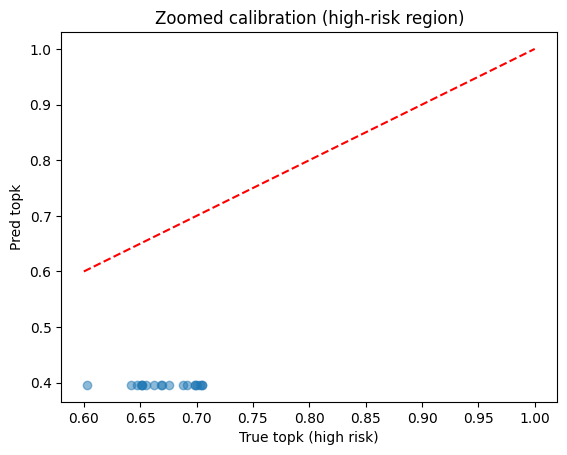

In [16]:
mask = ys_topk > 0.6  # or domain threshold

plt.scatter(ys_topk[mask], ph_topk[mask], alpha=0.5)
plt.plot([0.6,1.0], [0.6,1.0], "r--")
plt.xlabel("True topk (high risk)")
plt.ylabel("Pred topk")
plt.title("Zoomed calibration (high-risk region)")
plt.show()


## X Quantile-to-Quantile (QQ) plot (SPREAD CHECK) ✅
This answers: “Is variance preserved or crushed?”

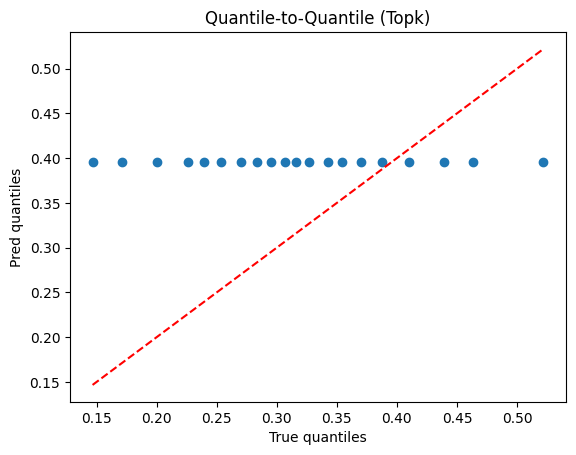

In [17]:
qs = np.linspace(0.05, 0.95, 20)

true_q = np.quantile(ys_topk, qs)
pred_q = np.quantile(ph_topk, qs)

plt.scatter(true_q, pred_q)
plt.plot([true_q.min(), true_q.max()],
         [true_q.min(), true_q.max()], "r--")
plt.xlabel("True quantiles")
plt.ylabel("Pred quantiles")
plt.title("Quantile-to-Quantile (Topk)")
plt.show()


## X True vs Predicted distribution (OPTIONAL, LAST)
Only useful after calibration is understood.

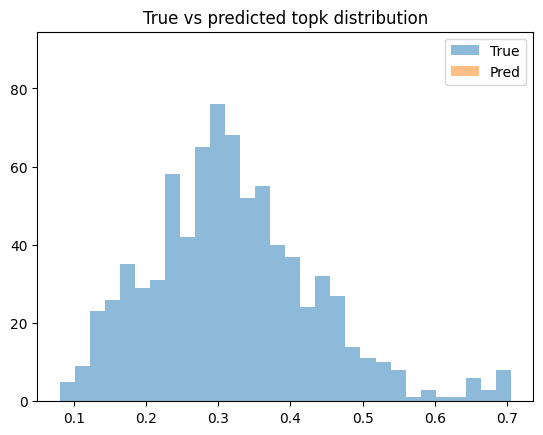

In [18]:
plt.hist(ys_topk, bins=30, alpha=0.5, label="True")
plt.hist(ph_topk, bins=30, alpha=0.5, label="Pred")
plt.legend()
plt.title("True vs predicted topk distribution")
plt.show()


# Time Window Clusters

* Handling with noisy windows, mix of toxic and normal

## X Time Window cluster dataset

In [21]:
class TimeWindowClusterDataset(Dataset):
    def __init__(
        self,
        embeddings,
        confidences,
        timestamps,
        window_seconds=300,   # 5 minutes
        cluster_size=64,
        n_clusters=6000,
        mix_ratio=0.3
    ):
        self.emb = embeddings
        self.conf = confidences
        self.ts = timestamps
        self.window = window_seconds
        self.cluster_size = cluster_size
        self.n_clusters = n_clusters
        self.mix_ratio = mix_ratio
        self.N = len(embeddings)

    def __len__(self):
        return self.n_clusters

    def __getitem__(self, idx):
        # 1️⃣ pick random anchor
        anchor = np.random.randint(0, self.N)
        t0 = self.ts[anchor]

        # 2️⃣ time filter
        mask = np.abs(self.ts - t0) <= self.window
        candidates = np.where(mask)[0]

        if len(candidates) < 10:
            candidates = np.arange(self.N)

        # 3️⃣ semantic neighbors inside time window
        emb_cand = self.emb[candidates]

        knn_local = NearestNeighbors(
            n_neighbors=min(len(candidates), self.cluster_size),
            metric="cosine"
        ).fit(emb_cand)

        _, idxs = knn_local.kneighbors(
            self.emb[anchor].reshape(1, -1)
        )

        local_idx = candidates[idxs[0]]

        # 4️⃣ inject noise
        n_local = int(self.cluster_size * (1 - self.mix_ratio))
        n_rand = self.cluster_size - n_local

        local_idx = np.random.choice(local_idx, n_local, replace=False)
        rand_idx = np.random.choice(self.N, n_rand, replace=False)

        indices = np.concatenate([local_idx, rand_idx])
        np.random.shuffle(indices)

        # 5️⃣ assemble cluster
        X = self.emb[indices]
        conf = self.conf[indices]

        # --- labels ---
        y_mean = float(conf.mean())

        # concentration (Gini)
        conf_sorted = np.sort(conf)
        n = len(conf_sorted)
        cum = np.cumsum(conf_sorted)
        y_topk = (n + 1 - 2 * np.sum(cum) / cum[-1]) / n
        y_topk = float(np.clip(y_topk, 0.0, 1.0))

        y = torch.tensor([y_mean, y_topk], dtype=torch.float32)
        return torch.tensor(X, dtype=torch.float32), y

## X Data Loader

In [22]:
# --- 6th iteration - TimedWindowClusterDataset - Sanity

# We don’t have real timestamps yet, fake them for now
timestamps = np.sort(np.random.randint(0, 86400, size=len(embeddings)))

time_window_dataset = TimeWindowClusterDataset(
    embeddings=embeddings,
    confidences=confidences,
    timestamps=timestamps,   # ✅ FIXED
    window_seconds=300,
    cluster_size=64,
    n_clusters=6000,
    mix_ratio=0.3
)

time_window_loader = DataLoader(time_window_dataset, batch_size=32, shuffle=True, drop_last=True)

print("kNN cluster dataset ready")


kNN cluster dataset ready


## X Inspect data (ESB?)


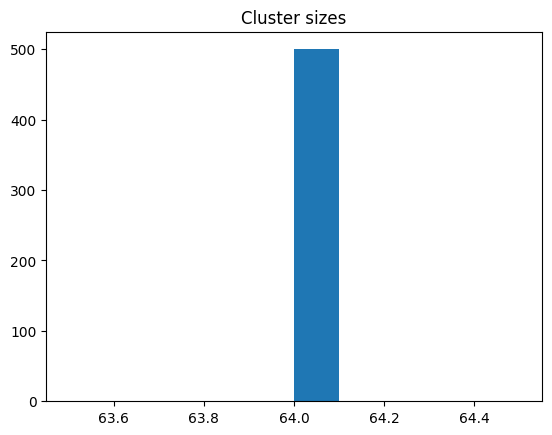

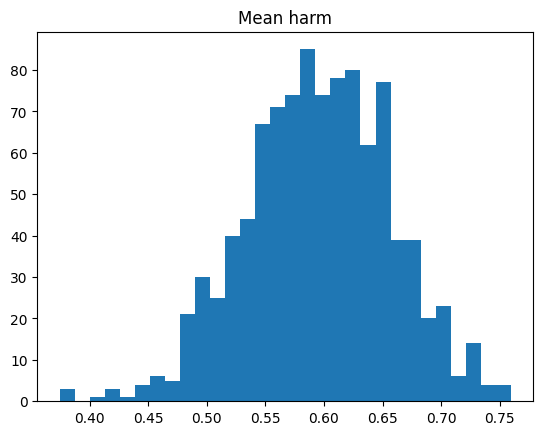

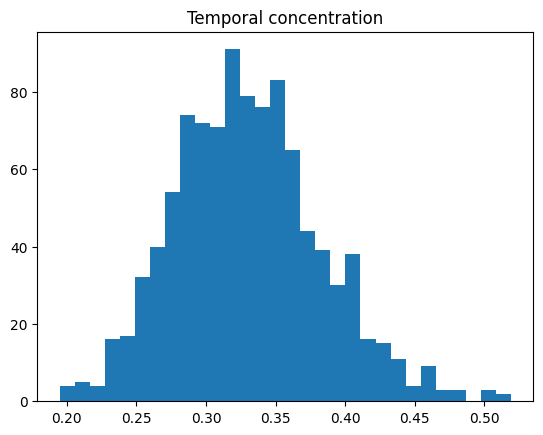

In [23]:
# -- Window density

sizes = []
for i in range(500):
    X, _ = time_window_dataset[i]
    sizes.append(X.shape[0])

plt.hist(sizes); plt.title("Cluster sizes"); plt.show()



# -- Label distribution

ys_mean, ys_topk = [], []

for i in range(1000):
    _, y = time_window_dataset[i]
    ys_mean.append(y[0].item())
    ys_topk.append(y[1].item())

plt.hist(ys_mean, bins=30); plt.title("Mean harm"); plt.show()
plt.hist(ys_topk, bins=30); plt.title("Temporal concentration"); plt.show()

## X Load model


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SetTransformerDualHead().to(device)
model.load_state_dict(torch.load(f"{MODEL_DIR}/settransformer_knn_pretrained.pt"))

## 4.a. Train on time window

In [21]:
# --- Train on both heads

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# --- 4 - Change topk to represent concentration vs. volume (? - need to validate it)
criterion = nn.MSELoss()
w_mean = 1.0
w_topk = 4.0 # Harder signal, higher weight

for epoch in range(5):
    model.train()
    total = 0.0

    for X, y in tqdm(time_window_loader):
        X = X.to(device)      # [B, N, D]
        y = y.to(device)      # [B, 2]

        optimizer.zero_grad()
        y_hat = model(X)      # [B, 2]

        # ---- shape safety ----
        if y_hat.dim() == 1:
            y_hat = y_hat.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(0)

        loss_mean = criterion(y_hat[:, 0], y[:, 0])
        loss_topk = criterion(y_hat[:, 1], y[:, 1])
        loss = w_mean * loss_mean + w_topk * loss_topk

        loss.backward()
        optimizer.step()
        total += loss.item()

    print(f"Epoch {epoch+1} | loss={total/len(time_window_loader):.6f} | mean={loss_mean.item():.4f} topk={loss_topk.item():.4f}")


100%|██████████| 187/187 [00:18<00:00, 10.19it/s]


Epoch 1 | loss=0.016289 | mean=0.0031 topk=0.0019


100%|██████████| 187/187 [00:18<00:00, 10.16it/s]


Epoch 2 | loss=0.014597 | mean=0.0033 topk=0.0027


100%|██████████| 187/187 [00:18<00:00,  9.96it/s]


Epoch 3 | loss=0.014164 | mean=0.0027 topk=0.0022


100%|██████████| 187/187 [00:18<00:00, 10.06it/s]


Epoch 4 | loss=0.014072 | mean=0.0055 topk=0.0036


100%|██████████| 187/187 [00:18<00:00, 10.18it/s]

Epoch 5 | loss=0.014226 | mean=0.0042 topk=0.0026


## 4.b. Plot prediction distribution

In [26]:
import numpy as np

preds_mean = np.array(preds_mean)
preds_topk = np.array(preds_topk)

print("mean head:")
print("  min / max:", np.nanmin(preds_mean), np.nanmax(preds_mean))
print("  nan count:", np.isnan(preds_mean).sum())

print("topk head:")
print("  min / max:", np.nanmin(preds_topk), np.nanmax(preds_topk))
print("  nan count:", np.isnan(preds_topk).sum())


print("std mean:", preds_mean.std())
print("std topk:", preds_topk.std())


mean head:
  min / max: 0.60194576 0.6019473
  nan count: 0
topk head:
  min / max: 0.32208642 0.32208732
  nan count: 0
std mean: 2.72609e-07
std topk: 1.4024455e-07


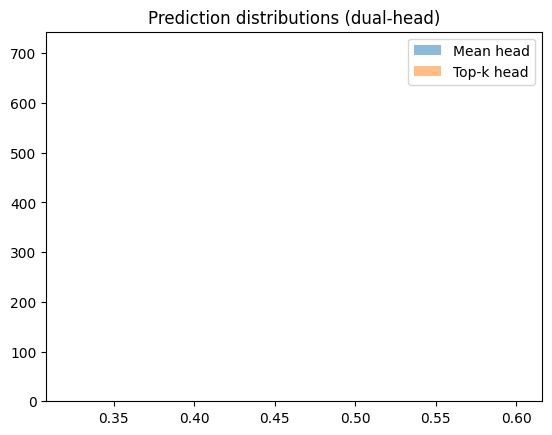

In [24]:
preds_mean = []
preds_topk = []

model.eval()
with torch.no_grad():
    for i in range(5000):
        X, _ = time_window_dataset[i]
        X = X.unsqueeze(0).to(device)
        y_hat = model(X).cpu().numpy()[0]

        preds_mean.append(y_hat[0])
        preds_topk.append(y_hat[1])

plt.hist(preds_mean, bins=30, alpha=0.5, label="Mean head")
plt.hist(preds_topk, bins=30, alpha=0.5, label="Top-k head")
plt.legend()
plt.title("Prediction distributions (dual-head)")
plt.show()

# X Single Head SetTransforer Regressor

## X Single Head SetTransformer Regressor

In [6]:
class SetTransformerRegressor(nn.Module):
    def __init__(self, dim_in=384, dim=256, num_heads=4, num_inducing=16):
        super().__init__()
        self.enc1 = ISAB(dim_in=dim_in, dim_out=dim, num_heads=num_heads, num_inducing=num_inducing)
        self.enc2 = ISAB(dim_in=dim, dim_out=dim, num_heads=num_heads, num_inducing=num_inducing)
        self.pool = PMA(dim=dim, num_heads=num_heads, num_seeds=1)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # outputs in [0,1] since label is mean confidence
        )

    def forward(self, X):
        # X: [B, N, D]
        H = self.enc1(X)
        H = self.enc2(H)
        P = self.pool(H).squeeze(1)  # [B, dim]
        y = self.head(P).squeeze(-1) # [B]
        return y


## X Train single transformer

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SetTransformerRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.SmoothL1Loss()

In [13]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total = 0.0

    for X, y in tqdm(knn_loader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        total += loss.item()

    print(f"Epoch {epoch+1} | loss = {total/len(knn_loader):.6f}")


  0%|          | 0/187 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:1077: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
  0%|          | 0/187 [00:02<?, ?it/s]


RuntimeError: The size of tensor a (32) must match the size of tensor b (2) at non-singleton dimension 1